In [1]:
import pandas as pd
import numpy as np

from itertools import combinations, product
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM

In [2]:
df = pd.read_csv('./data.csv', index_col=0)
deaths_df = df.drop(['new_confirmed_cases'], axis=1).iloc[35:]
deaths_df.head()

,no2,pm25,ozone,new_deaths
Date,,,,
2020-03-01,0.007,11.1,0.045,0.0
2020-03-02,0.022,8.4,0.043,0.0
2020-03-03,0.029,9.4,0.038,0.0
2020-03-04,0.021,15.8,0.029,0.0
2020-03-05,0.029,22.1,0.033,0.0


In [3]:
feature_combinations = []
features = [col for col in deaths_df.columns if col == 'new_deaths']
feature_combinations = list(product(features))
feature_combinations

[('new_deaths',)]

In [21]:
training_results = {}
days_in = 14
days_out = 5
n_train = int(len(deaths_df)*.8)
length = len([col for col in deaths_df.columns if col == 'new_deaths'])
features = []
models = []
histories = []
y_and_yhats = []
error_days_out_dicts = []
    
df = deaths_df[['new_deaths']]

# Rescale data and reframe to work with LSTM 
reframed, scaler = scale_vals(df, days_in, days_out)
# cols_to_keep = list(range(1, days_out * (length+1), (length+1)))
# cols_to_drop = [-i for i in range(1,days_out * (length + 1) +1) if i not in cols_to_keep]
# reframed.drop(reframed.columns[cols_to_drop], axis=1, inplace=True)
print(reframed)
reframed_vals = reframed.values

# Split into training and testing datasets, and reshape to work with LSTM
train = reframed_vals[:n_train]
test = reframed_vals[n_train:]
X_train, y_train = train[:,:-days_out],train[:,-days_out:]
X_test, y_test = test[:,:-days_out],test[:,-days_out:]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build and train the model
print(f'\n======= Training {list(df.columns)[:length]} =======\n')
model = build_model(X_train, days_out)
stop_noimprovement = EarlyStopping(monitor='val_loss', verbose=1, patience=30, min_delta=.00001)
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,verbose=1,callbacks=[stop_noimprovement],shuffle=False)

# Derive predictions
predictions = model.predict(X_test)
y_and_yhat = {}

for day in range(1, days_out+1):
    y_and_yhat[day] = []

for (prediction, actual) in zip(predictions, y_test):
    for i, day_ahead in enumerate(prediction):
        '''
        - Prediction = [f1, f2, f3, target]
        - np.concatenate(([0]*length, [day_ahead])) replaces features with zeros and
            keeps day_ahead value
        - .reshape(1,-1) makes 2d array (format required by scaler)
        - scaler.inverse_transform(predicted) returns 2d array of transformed values
        - we only care about the target, so we get the last element
        '''
        # transform predictions
        predicted = np.concatenate(([0]*length, [day_ahead])).reshape(1,-1)
        predict = scaler.inverse_transform(predicted)[0][-1]

        # transform y_test
        actual_r = np.concatenate(([0]*length, [actual[i]])).reshape(1,-1)
        a = scaler.inverse_transform(actual_r)[0][-1]
        
        # y_and_yhat dict has the day ahead as the key
        # and a list of tuples (actual, prediction) as the value
        y_and_yhat[i+1].append((a, predict))

error_days_out = {}
for day in range(1, days_out+1):
    actual_vals = [vals[0] for vals in y_and_yhat[day]]
    prediction_vals = [vals[1] for vals in y_and_yhat[day]]
    rmse = np.sqrt(mean_squared_error(actual_vals, prediction_vals))
    nrmse = rmse/(df['new_deaths'].max() - df['new_deaths'].min())
    error_days_out[day] = (rmse, nrmse)

features.append(list(df.columns[:-1]))
models.append(model)
histories.append(history)
y_and_yhats.append(y_and_yhat)
error_days_out_dicts.append(error_days_out)

     var1(t-14)  var1(t-13)  var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  \
14    -1.000000   -1.000000   -1.000000   -1.000000   -1.000000  -1.000000   
15    -1.000000   -1.000000   -1.000000   -1.000000   -1.000000  -1.000000   
16    -1.000000   -1.000000   -1.000000   -1.000000   -1.000000  -1.000000   
17    -1.000000   -1.000000   -1.000000   -1.000000   -1.000000  -1.000000   
18    -1.000000   -1.000000   -1.000000   -1.000000   -1.000000  -1.000000   
..          ...         ...         ...         ...         ...        ...   
272   -0.538462   -0.956044   -0.868132   -0.450549   -0.186813  -0.384615   
273   -0.956044   -0.868132   -0.450549   -0.186813   -0.384615  -0.296703   
274   -0.868132   -0.450549   -0.186813   -0.384615   -0.296703  -0.296703   
275   -0.450549   -0.186813   -0.384615   -0.296703   -0.296703  -0.802198   
276   -0.186813   -0.384615   -0.296703   -0.296703   -0.802198  -0.604396   

     var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var

Epoch 38/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1338 - val_loss: 0.0792
Epoch 39/200
224/224 [==============================] - 0s 922us/sample - loss: 0.1331 - val_loss: 0.0782
Epoch 40/200
224/224 [==============================] - 0s 944us/sample - loss: 0.1324 - val_loss: 0.0774
Epoch 41/200
224/224 [==============================] - 0s 934us/sample - loss: 0.1318 - val_loss: 0.0766
Epoch 42/200
224/224 [==============================] - 0s 939us/sample - loss: 0.1312 - val_loss: 0.0760
Epoch 43/200
224/224 [==============================] - 0s 933us/sample - loss: 0.1306 - val_loss: 0.0755
Epoch 44/200
224/224 [==============================] - 0s 962us/sample - loss: 0.1301 - val_loss: 0.0750
Epoch 45/200
224/224 [==============================] - 0s 1ms/sample - loss: 0.1295 - val_loss: 0.0747
Epoch 46/200
224/224 [==============================] - 0s 963us/sample - loss: 0.1290 - val_loss: 0.0744
Epoch 47/200
224/224 [============================

In [22]:
df_cols = {'features': features, 'model':models, 'history':histories, 'y_and_yhat': y_and_yhats}
days_out = 5
for day in range(1, days_out+1):
    df_cols[f'{day} day(s) out RMSE'] = [errs[day][0] for errs in error_days_out_dicts]
    df_cols[f'{day} day(s) out nRMSE'] = [errs[day][1] for errs in error_days_out_dicts]
results = pd.DataFrame(df_cols)
results

,features,model,history,y_and_yhat,1 day(s) out RMSE,1 day(s) out nRMSE,2 day(s) out RMSE,2 day(s) out nRMSE,3 day(s) out RMSE,3 day(s) out nRMSE,4 day(s) out RMSE,4 day(s) out nRMSE,5 day(s) out RMSE,5 day(s) out nRMSE
0,[],<tensorflow.python.keras.engine.sequential.Seq...,<tensorflow.python.keras.callbacks.History obj...,"{1: [(3.9999996609985913, 31.877503874997977),...",13.190456,0.14495,12.749086,0.1401,11.801805,0.12969,11.848538,0.130204,12.978165,0.142617


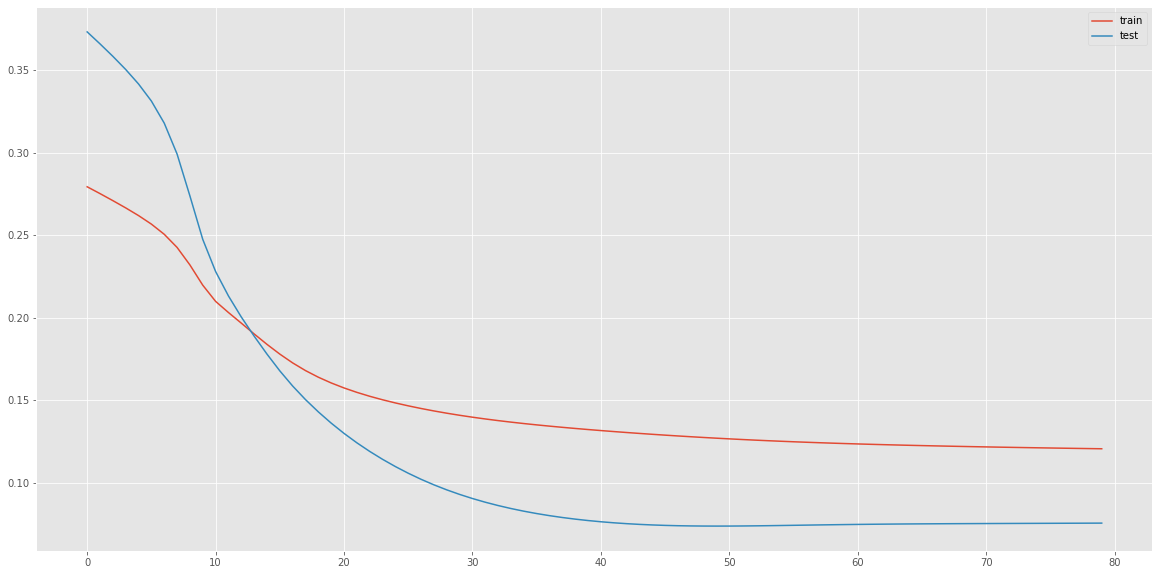

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
c = [col for col in list(results.columns) if col == 'features' or ('nRMSE' in col)]
nrmse_results = results[c]
nrmse_results.style.highlight_min(color = 'lightgreen', axis = 1)

,features,1 day(s) out nRMSE,2 day(s) out nRMSE,3 day(s) out nRMSE,4 day(s) out nRMSE,5 day(s) out nRMSE
0,[],0.144950,0.140100,0.129690,0.130204,0.142617


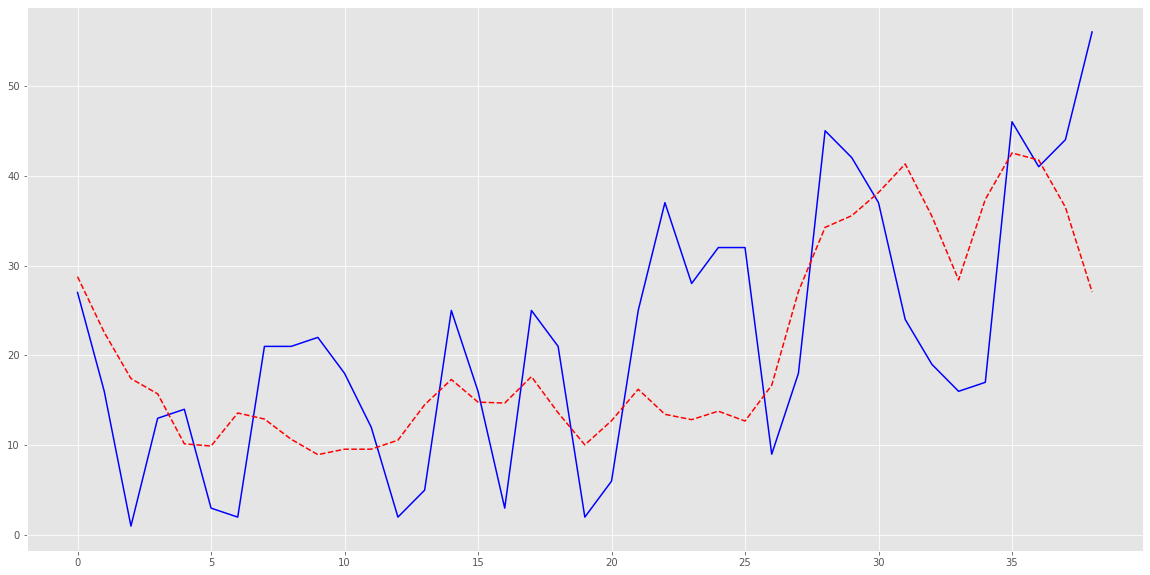

In [25]:
index = 0
days_out_index = 3
acts = [vals[0] for vals in y_and_yhat[days_out_index]]
preds = [vals[1] for vals in y_and_yhat[days_out_index]]
plt.plot(acts, color='blue')
plt.plot(preds,'--', color='red')
plt.show()

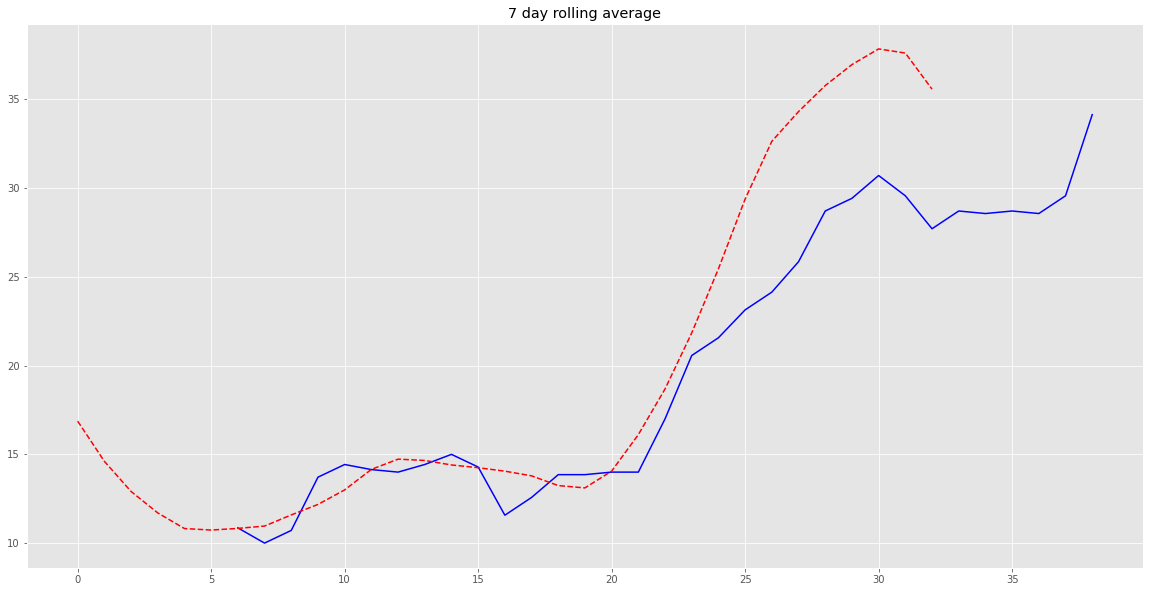

In [26]:
index = 0
days_out = 3
window_size = 7

acts = [vals[0] for vals in results.iloc[index]['y_and_yhat'][days_out]]
numbers_series = pd.Series(acts)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()
moving_averages_list = moving_averages.tolist()
plt.plot(moving_averages_list, color='blue')

preds = [vals[1] for vals in results.iloc[index]['y_and_yhat'][days_out]]
numbers_series = pd.Series(preds)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()
moving_averages_list = moving_averages.tolist()
without_nans = moving_averages_list[window_size - 1:]

plt.plot(without_nans,'--', color='red')
plt.title('7 day rolling average')
plt.show()

In [7]:
def scale_vals(data, n_in, n_out):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled,n_in,n_out)
    return reframed, scaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def build_model(X_train, days_out):
    model = Sequential()
    model.add(LSTM(20,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(60,return_sequences=True))
#     model.add(d)
    model.add(LSTM(100,return_sequences=True))
    model.add(LSTM(40,return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(days_out))
    model.compile(loss="mse",optimizer="adam")
    print(model.summary())
    return model